In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import qriemannopt as qro
from MERAOpt import MERAOpt
import math

### Random ill conditioned hamiltonian with negative spectrum

C:\Users\HYPERPC\Anaconda3\lib\site-packages\numpy\core\numeric.py:591: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


Text(0, 0.5, '-eigval')

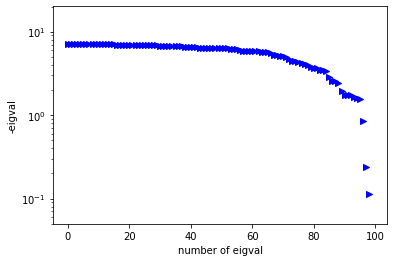

In [2]:
ham_dim = 100 # dimension of a hamiltonian
renorm_ham_dim = 30 # dimension of a renormalized hamiltonian

# hamiltonian
Q = qro.manifold.real_to_complex(tf.random.normal((ham_dim, ham_dim, 2), dtype=tf.float64))
Q, _ = tf.linalg.qr(Q)
S = tf.random.uniform((ham_dim,), -2, 2)
S = tf.exp(S)
S = tf.cast(S - tf.reduce_max(S), dtype=tf.complex128)
H = tf.einsum('ik,k,jk->ij', Q, S, tf.math.conj(Q))

# plotting of spectrum
plt.ylim(top=math.exp(3), bottom=math.exp(-3))
plt.scatter(tf.range(0, H.shape[0]), -tf.linalg.eigvalsh(H), color='blue', marker='>')
plt.yscale('log')
plt.xlabel('number of eigval')
plt.ylabel('-eigval')

### Initial isometric matrix, exact minimum, and different optimizers

In [3]:
# initial isometric matrix
q_in = tf.complex(tf.random.normal((ham_dim, renorm_ham_dim), dtype=tf.float64),
               tf.random.normal((ham_dim, renorm_ham_dim), dtype=tf.float64))
q_in, _ = tf.linalg.qr(q_in)
q_in = qro.manifold.complex_to_real(q_in)

# exact min value of quadratic problem
min_value = tf.cast(tf.reduce_sum(tf.linalg.eigvalsh(H)[:renorm_ham_dim]),
                   dtype=tf.float64)


#============================== Different retractions and metrics ===============================#
m_cayley = qro.manifold.StiefelManifold(retraction='cayley')
m_svd = qro.manifold.StiefelManifold()
m_cayley_canonical = qro.manifold.StiefelManifold(retraction='cayley', metric='canonical')
m_svd_canonical = qro.manifold.StiefelManifold(metric='canonical')
#================================================================================================#

#==================================== Different optimizers ======================================#
opts = {
        'GD_cayley':qro.optimizers.RSGD(m_cayley, 0.003),
        'GD_svd':qro.optimizers.RSGD(m_svd, 0.003),
        'GD_cayley_with_momentum':qro.optimizers.RSGD(m_cayley, 0.2, 0.9),
        'GD_svd_with_momentum':qro.optimizers.RSGD(m_svd, 0.2, 0.9),
        'Adam_cayley':qro.optimizers.RAdam(m_cayley, 0.3),
        'Adam_svd':qro.optimizers.RAdam(m_svd, 0.3),
        'Adam_cayley_with_ams':qro.optimizers.RAdam(m_cayley, 0.3, ams=True),
        'Adam_svd_with_ams':qro.optimizers.RAdam(m_svd, 0.3, ams=True),
        'GD_cayley_canonical':qro.optimizers.RSGD(m_cayley_canonical, 0.003),
        'GD_svd__canonical':qro.optimizers.RSGD(m_svd_canonical, 0.003),
        'GD_cayley_with_momentum_canonical':qro.optimizers.RSGD(m_cayley_canonical, 0.2, 0.9),
        'GD_svd_with_momentum_canonical':qro.optimizers.RSGD(m_svd_canonical, 0.2, 0.9),
        'Adam_cayley_canonical':qro.optimizers.RAdam(m_cayley_canonical, 0.3),
        'Adam_svd_canonical':qro.optimizers.RAdam(m_svd_canonical, 0.3),
        'Adam_cayley_with_ams_canonical':qro.optimizers.RAdam(m_cayley_canonical, 0.3, ams=True),
        'Adam_svd_with_ams_canonical':qro.optimizers.RAdam(m_svd, 0.3, ams=True),
        'MERAOpt': MERAOpt()
       }
#================================================================================================#

### Optimization loop

In [4]:
err_dict = {} # will be filed by err list vs optimizer

# loop over optimizers
for key, opt in opts.items():
    
    err = [] # will be filled by err vs iter
    q = tf.Variable(q_in) # turning initial isometry to variable
    
    # optimization loop
    for _ in range(1000):
        with tf.GradientTape() as tape:
            Z = tf.complex(q[..., 0], q[..., 1])
            loss = tf.cast(tf.linalg.trace((tf.linalg.adjoint(Z) @ H @ Z)),
                        dtype=tf.float64)
            err.append(loss - min_value)
        grad = tape.gradient(loss, q)
        opt.apply_gradients(zip([grad], [q]))
    err_dict[key] = err

### Plotting error plot per optimizer

Text(0, 0.5, 'err')

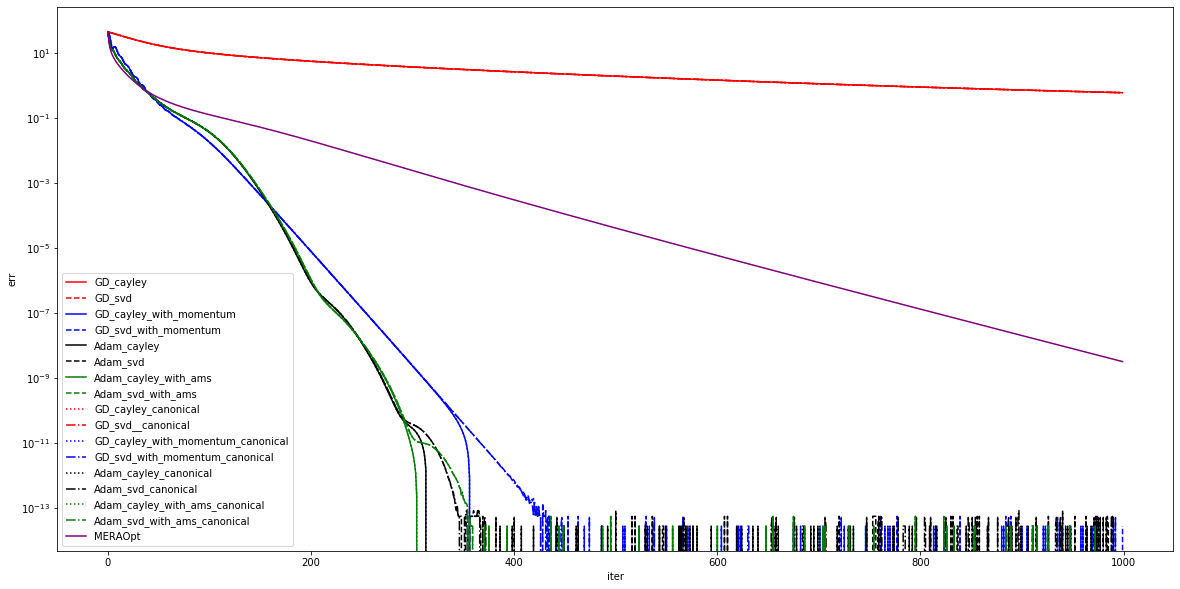

In [5]:
colors = ['r', 'r--', 'b', 'b--', 'k', 'k--', 'g', 'g--', 'r:', 'r-.', 'b:', 'b-.', 'k:', 'k-.', 'g:', 'g-.', 'purple']
plt.figure(figsize=(20, 10))
for i, key in enumerate(opts.keys()):
    plt.plot(err_dict[key], colors[i])
plt.legend(opts.keys())
plt.yscale('log')
plt.xlabel('iter')
plt.ylabel('err')